#### This run is with centroids as layer to local only

In [22]:
### python packages
import os
from os import path
import numpy as np
import glob as glob
from random import random
import pandas as pd

### torch packages
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import Sampler

### sklearn packages
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold


### remove these later (for notebook version only)
from tqdm import tqdm_notebook as tqdm
'''
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, export_png
from bokeh.layouts import row
output_notebook()
'''

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [23]:
torch.cuda.is_available()

True

In [24]:
### set manual seed
torch.cuda.manual_seed(42)

In [28]:

class KeplerDataLoaderCrossVal(Dataset):
    
    '''
    
    PURPOSE: DATA LOADER FOR KERPLER LIGHT CURVES
    INPUT: PATH TO DIRECTOR WITH LIGHT CURVES + INFO FILES
    OUTPUT: LOCAL + GLOBAL VIEWS, LABELS
    
    '''

    def __init__(self, infofiles):
        ### list of global, local, and info files (assumes certain names of files)
        self.flist_global,self.flist_local=[],[]
        for i,val in enumerate(infofiles):
            self.flist_global.append(val.replace('_info2.npy','_glob.npy'))
            self.flist_local.append(val.replace('_info2.npy','_loc.npy'))
        self.flist_info = infofiles
        
        ### list of whitened centroid files
        #self.flist_global_cen = np.sort(glob.glob(os.path.join(filepath, '*global_cen_w.npy')))
        #self.flist_local_cen = np.sort(glob.glob(os.path.join(filepath, '*local_cen_w.npy')))
        
        ### ids = {TIC}_{TCE}
        self.ids = np.sort(['_'.join(x.split('/')[-1].split('_')[1:3]) for x in self.flist_global])

    def __len__(self):

        return self.ids.shape[0]

    def __getitem__(self, idx):

        ### grab local and global views
        data_global = np.nan_to_num(np.load(self.flist_global[idx],encoding='latin1'))
        data_local = np.nan_to_num(np.load(self.flist_local[idx],encoding='latin1'))

        ### grab centroid views
        data_global_cen = data_global[:,1]
        data_local_cen = data_local[:,1]
        
        data_global = data_global[:,0]
        data_local = data_local[:,0]
        
        ### info file contains: [0]kic, [1]tce, [2]period, [3]epoch, [4]duration, [5]label)
        data_info = np.load(self.flist_info[idx],encoding='latin1')
        #np.load(self.flist_info[idx],encoding='latin1')
        
        if data_info[6]=='PL':
            label=1
        elif data_info[6]=='UNK':
            label=0
        elif data_info[6]=='EB':
            label=2
        else:
            label=3
        
        #collist=['TPERIOD','TDUR','DRRATIO','NTRANS','TSNR','TDEPTH','INDUR',
        #         'SESMES_LOG_RATIO','PRAD_LOG_RATIO','TDUR_LOG_RATIO','RADRATIO','IMPACT',
        #         'TESSMAG','RADIUS','PMTOTAL','LOGG','MH','TEFF']#from bls search, derived from transit model, from starpars
        stelpars=np.nan_to_num(np.hstack((data_info[7:13].astype(float),data_info[-18:-6].astype(float))))
        
        return (data_local.astype(float), data_global.astype(float), data_local_cen.astype(float), data_global_cen.astype(float), stelpars), label
    
class BalancedBatchSampler(Sampler):
    """Wraps another sampler to yield a class-balanced mini-batch of indices.

    Args:
        batch_size (int): Size of mini-batch.
        label_index (int): The index of the label in the dataset returned tuple
        shuffle (bool): Whether to shuffle every iteration or not.
    """
    def __init__(self, batch_size, dataset, n_classes, label_index=1, shuffle=True, stats_file=None):
        self.n_classes = n_classes
        self.dataset = dataset
        self.label_index = label_index
        self.batch_size = batch_size
        self.class_indices = []
        self.class_iteration_index = [0]*self.n_classes
        self.max_class_length = 0
        self.max_class = 0
        self.per_class_batchsize = self.batch_size // self.n_classes
        self.shuffle = shuffle

        for i in range(self.n_classes):
            self.class_indices.append([])

        if stats_file is not None and os.path.exists(stats_file):
            with open(stats_file, 'rb') as stats_f:
                self.class_indices = pickle.load(stats_f)
            print('Loaded dataset class distribution from: {}'.format(stats_file))
        else:
            print('Accumulating dataset class distribution...')
            for i in np.arange(len(self.dataset)):
                label = int(self.dataset[i][self.label_index])
                self.class_indices[label].append(i)
            if stats_file is not None:
                with open(stats_file, 'wb') as stats_f:
                    pickle.dump(self.class_indices, stats_f)
                print('Saved dataset class distribution to: {}'.format(stats_file))

        for i in range(self.n_classes):
            if self.shuffle:
                self.class_indices[i] = list(np.random.permutation(self.class_indices[i]))

            if len(self.class_indices) > self.max_class_length:
                self.max_class_length = len(self.class_indices[i])
                self.max_class = i
        
        print('Balancing dataset with class distribution: {}'.format([len(class_ind) for class_ind in self.class_indices]))

    def __iter__(self):
        # only generate full batches
        while self.class_iteration_index[self.max_class] + self.per_class_batchsize  < self.max_class_length:
            batch = []

            random_class_indices = []
            for i in range(self.n_classes):
                # if not majority class, and we ran out of samples, reset
                if i!= self.max_class and len(self.class_indices[i]) < self.class_iteration_index[i] + self.per_class_batchsize:
                    self.class_iteration_index[i] = 0
                j = self.class_iteration_index[i]
                sliced = self.class_indices[i][j:j+self.per_class_batchsize] 
                batch.extend(sliced)
                self.class_iteration_index[i] += self.per_class_batchsize

            yield batch
            batch = []

        # reset indices for next epoch
        for i in range(self.n_classes):
            self.class_iteration_index[i] = 0
            if self.shuffle:
                self.class_indices[i] = list(np.random.permutation(self.class_indices[i]))

    def __len__(self):
        return self.max_class_length // self.per_class_batchsize
    

In [29]:
def WritePyFile(foldname, savename, savedicname, mod, aug, fpath, kcount, cont=False,batchsize=64,n_epochs=300,gpu=None):
    #Writes python file which can be run seperately to produce easily multithreaded runs...
    print(foldname, savename, savedicname, mod, aug, fpath)
    #Loads all possible classes and models
    with open(path.join(foldname,'exonet_basefile.py'),'r') as f_x:
        file2write=f_x.read()
    
    file2write+='''
#INPUTS:
foldname    = \"{foldname}\"
savename    = \"{savename}\"
savedicname = \"{savedicname}\"
mod         = \"{mod}\"
aug         = \"{aug}\"
fpath       = \"{fpath}\"
kcount      = \"{kcount}\"
#cont       = {cont}
'''.format(foldname=foldname,savename=savename,savedicname=savedicname,mod=mod,aug=aug,fpath=fpath,kcount=kcount,cont=str(cont))
    if gpu is None:
        file2write+='''
#Assigning a GPU:
os.environ['CUDA_VISIBLE_DEVICES'] = \"{count}\"
'''.format(count=str(int(np.floor(kcount/2))))
    else:
        file2write+='''
#Assigning a GPU:
os.environ['CUDA_VISIBLE_DEVICES'] = \"{count}\"
'''.format(count=str(int(gpu)))

    file2write+='''
model=Model().cuda()
lr = 2.05e-5
'''.format(modsel=models[mod])
    file2write+='''
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
batch_size = {batchsize}
n_epochs = {n_epochs}

print(savename,"Loading datasets")
kepler_val_data = KeplerDataLoaderCrossVal(infofiles=pickle.load(open(path.join(foldname,savename+'_valfiles.pickle'),'rb')))
kepler_train_data = KeplerDataLoaderCrossVal(infofiles=pickle.load(open(path.join(foldname,savename+'_trainfiles.pickle'),'rb')))
kepler_batch_sampler = pickle.load(open(path.join(foldname,savename+'_BBS.pickle'),'rb'))
kepler_data_loader = DataLoader(kepler_train_data, batch_sampler = kepler_batch_sampler, num_workers=4)
kepler_val_loader = DataLoader(kepler_val_data, batch_size=batch_size, shuffle=False, num_workers=4)
'''.format(foldname=foldname,savename=savename,batchsize=str(int(batchsize)),n_epochs=str(int(n_epochs)))

    if cont:
        #If continuing from saved state:
        file2write+='''
    
try:
    model.load_state_dict(torch.load(path.join(foldname,savename.replace('_comp','')+'_temp.pth')))
except:
    try:
        model.load_state_dict(torch.load(path.join(foldname,savename.replace('_comp','')+'.pth')))
        
    except:
        print("Cannot re-load .pth from file")
try:
    dic=pickle.load(open(path.join(foldname,savename.replace('_comp','')+'_tempdic.pickle'),'rb'))
except:
    try:
        dic=pickle.load(open(path.join(foldname,savename.replace('_comp','')+'_final_dic.pickle'),'rb'))
    except:
        print("Cannot re-load dic from file - neither", )

'''
    else:
        file2write+='''
dic=None
'''
    print(augment,aug)
    file2write+='''
print(savename,"starting training")
outputdic = train_model(n_epochs, kepler_data_loader, kepler_val_loader, model, criterion, optimizer,augment=\"{aug_str}\",savefile=path.join(foldname,savename+'_tempdic.pickle'),cont=dic)
print("saving "+savename)
torch.save(model.state_dict(),path.join(foldname,savename+'.pth'))
'''.format(aug_str=augment[aug])
    file2write+='''
outputdic['k']=kcount;outputdic['fpath']=fpath;outputdic['aug']=aug
outputdic['mod']=mod
outputdic['unqid']=fpath+'_'+aug+'_'+mod
'''
    file2write+='''
pickle.dump(outputdic,open(path.join(foldname,savename+'_final_dic.pickle'),'wb'))
if path.exists(path.join(foldname,\"{pickledic}\")):
    outputvals=pickle.load(open(path.join(foldname,\"{pickledic}\"),'rb'))
else:
    outputvals={{}}
outputvals[savename]=outputdic
pickle.dump(outputvals,open(path.join(foldname,\"{pickledic}\"),'wb'))
'''.format(pickledic=savedicname+'.pickle')
    #print(file2write[23095:])
    if not path.isdir(path.join(foldname,'run')):
        os.system('mkdir '+path.join(foldname,'run'))
    with open(path.join(foldname,'run',savename+'.py'),'w') as f:
        f.write(file2write)
    return path.join(foldname,'run',savename+'.py')


In [34]:
#Don't continue
cont=False

import pickle
savedicname=os.getcwd().split('/')[-1]+'_dic'
foldname=os.getcwd()
names_of_files=[]

#for batch in batch_sizes:
batch_size = 64
models={'Big':'ExtranetModel'}
augment={'all':'all'}
filepaths={'101':'/home/hosborn/TESS/processed_dv_101_centfixed2/'}

n_epochs=700

#N GPUS:
nkfolds=8

for fpath in filepaths:
    ### divide train and validation sets
    kf = KFold(n_splits=nkfolds, shuffle=True)
    files_all = np.sort(glob.glob(path.join(filepaths[fpath],'all','*info2.npy')))
    '''
    #kepler_train_data = KeplerDataLoader(filepath=path.join(filepaths[fpath],'train'))
    #kepler_val_data = KeplerDataLoader(filepath=path.join(filepaths[fpath],'val'))
    '''
    
    mod='Big'
    aug='all'
    ### loop over folds
    kcount = 0
    precision_all, recall_all, ap_all = [], [], []
    for train_index, val_index in kf.split(files_all):
        ### initialize model

        savename='exonet_CV_'+str(kcount)+'.'+str(nkfolds)+'_'+fpath+'_'+aug+'_'+mod

        ### grab training and validation data
        files_train, files_val = files_all[train_index], files_all[val_index]
        pickle.dump(files_train,open(path.join(foldname,savename+'_trainfiles.pickle'),'wb'))
        pickle.dump(files_val,open(path.join(foldname,savename+'_valfiles.pickle'),'wb'))

        kepler_val_data = KeplerDataLoaderCrossVal(infofiles=files_val)
        kepler_train_data = KeplerDataLoaderCrossVal(infofiles=files_train)

        #Loading balancer:
        if not path.exists(path.join(foldname,savename+'_BBS.pickle')):
            kepler_batch_sampler = BalancedBatchSampler(batch_size, kepler_train_data, 4) #batch_size, dataset, n_classes
            pickle.dump(kepler_batch_sampler, open(path.join(foldname,savename+'_BBS.pickle'),'wb'))

        names_of_files+=['python3 '+WritePyFile(foldname,savename,savedicname,mod,aug,fpath,kcount,cont=cont,n_epochs=n_epochs,gpu=np.arange(8)[kcount])]
        kcount+=1

with open(path.join(foldname,'all_exonet_multiclass_run.sh'),'w') as f_runall:
    print("\n#Running all files in "+foldname+' \n'+' &\n'.join(names_of_files))
    f_runall.write("#Running all files in "+foldname+' \n'+' &\n'.join(names_of_files))

os.system('chmod +x *_exonet_multiclass_run.sh')

/home/hosborn/TESS/final_runs/exonet_multiclass4_CV_globcents3b_k8 exonet_CV_0.8_101_all_Big exonet_multiclass4_CV_globcents3b_k8_dic Big all 101
{'all': 'all'} all
/home/hosborn/TESS/final_runs/exonet_multiclass4_CV_globcents3b_k8 exonet_CV_1.8_101_all_Big exonet_multiclass4_CV_globcents3b_k8_dic Big all 101
{'all': 'all'} all
/home/hosborn/TESS/final_runs/exonet_multiclass4_CV_globcents3b_k8 exonet_CV_2.8_101_all_Big exonet_multiclass4_CV_globcents3b_k8_dic Big all 101
{'all': 'all'} all
/home/hosborn/TESS/final_runs/exonet_multiclass4_CV_globcents3b_k8 exonet_CV_3.8_101_all_Big exonet_multiclass4_CV_globcents3b_k8_dic Big all 101
{'all': 'all'} all
/home/hosborn/TESS/final_runs/exonet_multiclass4_CV_globcents3b_k8 exonet_CV_4.8_101_all_Big exonet_multiclass4_CV_globcents3b_k8_dic Big all 101
{'all': 'all'} all
/home/hosborn/TESS/final_runs/exonet_multiclass4_CV_globcents3b_k8 exonet_CV_5.8_101_all_Big exonet_multiclass4_CV_globcents3b_k8_dic Big all 101
{'all': 'all'} all
/home/hosb

0

In [ ]:
[10297, 3039, 5806]

In [4]:
#batch_sizes={'32':32,'64':64}
batch_size = 64
#lrs={'slow':5e-5,'fast':5e-4}
filepaths={'101':'/home/hosborn/TESS/processed_dv_101_centfixed2/'}
models={'Big':'ExtranetModel'}
#augment={'none':'','all':'all','noise':'noise','xshift':'xshift','yshift':'yshift','mirror':'mirror'}
augment={'all':'all'}
#augment={'all':'all','noise':'noise'}#,'xshift':'xshift','mirror':'mirror'}
#augment={'all':'all'}

In [13]:
nkfolds=5

In [ ]:
import pickle
savedicname='all_exonet_multiclass_CV_wfixedcent_dic'
foldname='exonet_multiclass_CV_wfixedcent'

if path.exists(path.join(foldname,savedicname+'.pickle')):
    outputvals=pickle.load(open(path.join(foldname,savedicname+'.pickle'),'rb'))
else:
    outputvals={}

if not path.isdir(foldname):
    os.system('mkdir '+foldname)

In [ ]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,14))

#for batch in batch_sizes:
#    for lr in lrs:           
models={'Big':'ExtranetModel'}
augment={'all':'all'}

for fpath in filepaths:
    ### divide train and validation sets
    kf = KFold(n_splits=nkfolds, shuffle=True)
    files_all = np.sort(glob.glob(path.join(filepaths[fpath],'all','*info.npy')))
    '''
    #kepler_train_data = KeplerDataLoader(filepath=path.join(filepaths[fpath],'train'))
    #kepler_val_data = KeplerDataLoader(filepath=path.join(filepaths[fpath],'val'))
    '''
    
    for mod in models:
        for aug in augment:
            ### loop over folds
            kcount = 0
            precision_all, recall_all, ap_all = [], [], []
            for train_index, val_index in kf.split(files_all):
                ### initialize model
                if mod=='Big':
                    #Have to have separate models for Big as no global pooling means 201-long LC produces more params
                    model=eval(models[mod]+'_'+fpath+'().cuda()')
                    lr = 1.5e-6
                else:
                    model=models[mod]().cuda()
                    lr = 2.5e-4
                
                savename='exonet_CV'+str(kcount)+'_'+fpath+'_'+aug+'_'+mod
                
                
                
                if savename not in list(outputvals.keys()):
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                    criterion = nn.BCELoss()
                    batch_size = 64
                    n_epochs = 300
                    
                    ### grab training and validation data
                    files_train, files_val = files_all[train_index], files_all[val_index]
                    kepler_val_data = KeplerDataLoaderCrossVal(infofiles=files_val)
                    kepler_train_data = KeplerDataLoaderCrossVal(infofiles=files_train)
                        
                    #Loadingin balancer:
                    fname=path.join(foldname,savename+'_BBS.pickle')
                    if path.exists(fname):
                        kepler_batch_sampler = pickle.load(open(fname,'rb'))
                    else:
                        kepler_batch_sampler = BalancedBatchSampler(batch_size, kepler_train_data, 2) #batch_size, dataset, n_classes
                        pickle.dump(kepler_batch_sampler, open(fname,'wb'))
                    
                    WritePyFile(balancerfname=fname)
                    
                    kepler_data_loader = DataLoader(kepler_train_data, batch_sampler = kepler_batch_sampler, num_workers=4)
                    kepler_val_loader = DataLoader(kepler_val_data, batch_size=batch_size, shuffle=False, num_workers=4)
                
                    
                    
                    if not path.exists(path.join(foldname,savename+'.pth')):

                        ### train model
                        print("training "+savename)
                        loss_train_epoch, loss_val_epoch, acc_val_epoch, ap_val_epoch, pred_val_final, gt_val_final  = train_model(n_epochs, kepler_data_loader, kepler_val_loader, model, criterion, optimizer,augment=augment[aug])
                        print("saving "+savename)
                        torch.save(model.state_dict(),path.join(foldname,savename+'.pth'))
                    else:
                        model.load_state_dict(torch.load(path.join(foldname,savename+'.pth')))
                        loss_train_epoch, loss_val_epoch, acc_val_epoch, ap_val_epoch, pred_val_final, gt_val_final  = train_model(3, kepler_data_loader, kepler_val_loader, model, criterion, optimizer,augment=augment[aug])
                    
                    outputvals[savename]={'loss_train_epoch':loss_train_epoch, 'loss_val_epoch':loss_val_epoch,
                                          'acc_val_epoch':acc_val_epoch,'ap_val_epoch':ap_val_epoch,
                                          'pred_val_final':pred_val_final, 'gt_val_final':gt_val_final,
                                          'k':kcount,'fpath':fpath,'aug':aug,'mod':mod,'unqid':fpath+'_'+aug+'_'+mod}
                
                else:
                    print("dictionary of trained values already exists")
                    '''
                    loss_train_epoch=outputvals[savename]['loss_train_epoch']
                    loss_val_epoch=outputvals[savename]['loss_val_epoch']
                    acc_val_epoch=outputvals[savename]['acc_val_epoch']
                    pred_val_final= outputvals[savename]['pred_val_final']
                    gt_val_final= outputvals[savename]['gt_val_final']
                    #tn, fp, fn, tp= outputvals[savename]['matrix_0.5']
                    #average_precision= outputvals[savename]['average_precision_pl']
                    
                    #epoch_val_recall_pl,epoch_val_recall_ebs,epoch_val_recall_unk = recall_val
                    #epoch_val_acc,epoch_val_acc_pl,epoch_val_acc_ebs,epoch_val_acc_unk = acc_val
                    outputvals[savename]={'loss_train_epoch':loss_train_epoch, 'loss_val_epoch':loss_val_epoch,
                              'acc_val_epoch':acc_val_epoch,'ap_val_epoch':ap_val_epoch,
                              'pred_val_final':pred_val_final, 'gt_val_final':gt_val_final,
                              'k':kcount,'fpath':fpath,'aug':aug,'mod':mod,'unqid':fpath+'_'+aug+'_'+mod}
                    '''
                kcount+=1
                pickle.dump(outputvals,open(path.join(foldname,savedicname+'.pickle'),'wb'))
                
            print('#Assembling Cross-Val results after '+str(kcount)+' CVs')
            dickeys=[key for key in outputvals if (outputvals[key]['unqid']==fpath+'_'+aug+'_'+mod)*~np.isnan(outputvals[key]['k'])]
            loss_train_epoch=[];loss_val_epoch=[];gt_val_final=[];pred_val_final=[]
            ap_val_epoch=[];acc_val_epoch=[]
            for key in dickeys:
                gt_val_final.append(outputvals[key]['gt_val_final'])
                pred_val_final.append(outputvals[key]['pred_val_final'])
                loss_train_epoch.append(outputvals[key]['loss_train_epoch'])
                loss_val_epoch.append(outputvals[key]['loss_val_epoch'])
                ap_val_epoch.append(outputvals[key]['ap_val_epoch'])
                acc_val_epoch.append(outputvals[key]['acc_val_epoch'])
            gt_val_final=np.hstack(gt_val_final)
            pred_val_final=np.hstack(pred_val_final)
            loss_train_epoch=[np.hstack(l) for l in loss_train_epoch]
            loss_val_epoch=[np.hstack(l) for l in loss_val_epoch]
            ap_val_epoch=[np.hstack(l) for l in ap_val_epoch]
            acc_val_epoch=[np.hstack(l) for l in acc_val_epoch]
            ### transform from loss per sample to loss per batch (multiple by batch size to compare to Chris')
            #loss_train_batch = [x.item()* batch_size for x in loss_train_epoch]
            #loss_val_batch = [x.item()* batch_size for x in loss_val_epoch]

            ### calculate average precision + precision-recall curves
            P, R, _ = precision_recall_curve(gt_val_final, pred_val_final)
            AP = average_precision_score(gt_val_final, pred_val_final, average='weighted')
            print("weighted average precision = {0:0.4f}".format(AP))

            ### convert prediction to bytes based on threshold
            thresh = [0.9, 0.7, 0.5]
            prec_thresh, recall_thresh = np.zeros(len(thresh)), np.zeros(len(thresh))
            for n, nval in enumerate(thresh):
                pred_byte = np.zeros(len(pred_val_final))
                for i, val in enumerate(pred_val_final):
                    if val > nval:
                        pred_byte[i] = 1.0
                    else:
                        pred_byte[i] = 0.0
                prec_thresh[n] = precision_score(gt_val_final, pred_byte)
                recall_thresh[n] = recall_score(gt_val_final, pred_byte)
                print(savename,": thresh = {0:0.2f}, precision = {1:0.2f}, recall = {2:0.2f}".format(thresh[n], prec_thresh[n], recall_thresh[n]))
                tn, fp, fn, tp = confusion_matrix(gt_val_final, pred_byte).ravel()
                print(savename,":    TN = {0:0}, FP = {1:0}, FN = {2:0}, TP = {3:0}".format(tn, fp, fn, tp))
            for key in dickeys:
                outputvals[key].update({'CV_P':P,'CV_R':R,'CV_AP':AP,'CV_matrix_0.5':[tn, fp, fn, tp]})
            
            outputvals['exonet_CVall_'+fpath+'_'+aug+'_'+mod]={'loss_train_epoch':loss_train_epoch, 'loss_val_epoch':loss_val_epoch,
                                          'acc_val_epoch':acc_val_epoch,'ap_val_epoch':ap_val_epoch,
                                          'pred_val_final':pred_val_final, 'gt_val_final':gt_val_final,
                                          'k':np.nan,'fpath':fpath,'aug':aug,'mod':mod,'unqid':fpath+'_'+aug+'_'+mod,
                                          'P':P,'R':R,'AP':AP,'matrix_0.5':[tn, fp, fn, tp]}

            plt.clf()
            plt.subplot(2,2,1)
            ### plot values
            plt.step(R, P)
            plt.title(fpath+'_'+aug+'_'+mod+': Precision vs. Recall, AP={0:0.3f}'.format(AP))

            plt.subplot(2,2,2)
            plt.title(fpath+'_'+aug+'_'+mod+': Loss per Epoch')
            #plt.plot(np.arange(len(loss_train_batch)), loss_train_batch,color=sns.color_palette()[0])
            #plt.plot(np.arange(len(loss_val_batch)), loss_val_batch,color=sns.color_palette()[1])
            for n,key in enumerate(dickeys):
                plt.plot(np.array(outputvals[key]['loss_train_epoch']),':',alpha=0.75,color=sns.color_palette()[n])
                plt.plot(np.array(outputvals[key]['loss_val_epoch']),'--',alpha=0.75,color=sns.color_palette()[n])
                plt.plot([0.0,0.0],[0.0,0.0],'-',alpha=0.75,label="k="+str(outputvals[key]['k']))
            plt.plot([0.0,0.0],[0.0,0.0],'--',label='validation')
            plt.plot([0.0,0.0],[0.0,0.0],':',label='training')
            plt.legend(loc=2)
            
            plt.subplot(2,2,3)
            plt.title(fpath+'_'+aug+'_'+mod+': Average Precision per Epoch')
            #plt.plot(np.arange(len(ap_val_epoch)), ap_val_epoch)
            for key in dickeys:
                plt.plot(outputvals[key]['ap_val_epoch'],'-',alpha=0.75)
                plt.plot([0.0,0.0],[0.0,0.0],'-',alpha=0.75,label="k="+str(outputvals[key]['k']))
            plt.legend(loc=4)
            
            plt.subplot(2,2,4)
            plt.title(fpath+'_'+aug+'_'+mod+': Accuracy per Epoch')
            #plt.plot(np.arange(len(acc_val_epoch)), acc_val_epoch)
            for key in dickeys:
                plt.plot(outputvals[key]['acc_val_epoch'],':',alpha=0.75)
                plt.plot([0.0,0.0],[0.0,0.0],'-',alpha=0.75,label="k="+str(outputvals[key]['k']))
            plt.legend(loc=4)
            
            plt.savefig(path.join(foldname,'exonet_CVall_'+fpath+'_'+aug+'_'+mod+".png"))
            pickle.dump(outputvals,open(path.join(foldname,savedicname+'.pickle'),'wb'))


In [29]:
torch.cuda.device_count()

4

In [13]:
import pickle
dic=pickle.load(open('exonet_CV_0.8_101_all_Big_tempdic.pickle','rb'))

In [15]:
dic

{'acc_val_epoch_bebs': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.8333333333333334,
  0.5675675675675675,
  0.6846846846846847,
  0.6666666666666666,
  0.6467065868263473,
  0.6194690265486725,
  0.6707317073170732,
  0.5182795698924731,
  0.5915032679738562,
  0

In [22]:
vals[0]

'/home/hosborn/TESS/processed_dv_101_centfixed2/all/000002529724_00_01_info.npy'

one run per GPU:

* 11 156.611 s/epoch , LOSS: train  =   [0.02326  ,   val  =  0.006663  ,   acc  =  0.84696
* 11 156.633 s/epoch , LOSS: train  =   [0.02421  ,   val  =  0.006407  ,   acc  =  0.85749
* 11 157.423 s/epoch , LOSS: train  =   [0.02325  ,   val  =  0.006607  ,   acc  =  0.84696
* 11 157.655 s/epoch , LOSS: train  =   [0.02450  ,   val  =  0.006902  ,   acc  =  0.83898

Projection: 26 hours for 8 folds



In [59]:
np.vstack([np.array([[5,2,1,3,2,6,1],[5,2,1,3,2,6,1],[5,2,1,3,2,6,1]]),np.array([[5,2,1,3,2,6,1],[5,2,1,3,2,6,1],[5,2,1,3,2,6,1],[5,2,1,3,2,6,1]]),np.array([[5,2,1,3,2,6,1]])])

array([[5, 2, 1, 3, 2, 6, 1],
       [5, 2, 1, 3, 2, 6, 1],
       [5, 2, 1, 3, 2, 6, 1],
       [5, 2, 1, 3, 2, 6, 1],
       [5, 2, 1, 3, 2, 6, 1],
       [5, 2, 1, 3, 2, 6, 1],
       [5, 2, 1, 3, 2, 6, 1],
       [5, 2, 1, 3, 2, 6, 1]])

In [45]:
Variable(np.array([5,2,1,3,2,6,1])[:,np.newaxis]).type(torch.LongTensor)

TypeError: Variable data has to be a tensor, but got numpy.ndarray

array([[5],
       [2],
       [1],
       [3],
       [2],
       [6],
       [1]])

In [33]:
with open(path.join(foldname,'all_exonet_binary_run.sh'),'w') as f_runall:
    f_runall.write("#Running all files in "+foldname+' \n\n'+' &\n'.join(names_of_files))


In [47]:
with open('exonet-run-all-cv-basefile.py','r') as f_x:
        file2write=f_x.read()
len(file2write)

23095

In [24]:
oldstring='formatted string'
print('''this is \"a\" {string}
        on multiple lines'''.format(string=oldstring))

this is "a" formatted string
        on multiple lines


In [ ]:
#10:04 - LOSS: train  =   [0.00733485]  ,   val  =   0.002784695541649534  ,   acc  =   0.9392712550607287
#11:02 - LOSS: train  =   [0.0071916]  ,   val  =   0.002710555315431382  ,   acc  =   0.9400424137266242

In [80]:
model.type

<bound method Module.type of ExtranetXSModel(
  (fc_global): Sequential(
    (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): ReLU()
  )
  (fc_local): Sequential(
    (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): ReLU()
  )
  (final_layer): Sequential(
    (0): Linear(in_features=54, out_features=1, bias=True)
    (1): Sigmoid()
  )
)>

### Re-running those models which did not converge with faster learning rate:

In [66]:
outputvals_contd=outputvals.copy()

In [163]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,14))

#for batch in batch_sizes:
#    for lr in lrs:            

for fpath in filepaths:
    ### divide train and validation sets
    kf = KFold(n_splits=nkfolds, shuffle=True)
    files_all = np.sort(glob.glob(path.join(filepaths[fpath],'all','*info.npy')))
    '''
    #kepler_train_data = KeplerDataLoader(filepath=path.join(filepaths[fpath],'train'))
    #kepler_val_data = KeplerDataLoader(filepath=path.join(filepaths[fpath],'val'))
    '''
    
    for mod in models:
        for aug in augment:
            ### loop over folds
            kcount = 0
            precision_all, recall_all, ap_all = [], [], []
            for train_index, val_index in kf.split(files_all):
                savename='exonet_CV'+str(kcount)+'_'+fpath+'_'+aug+'_'+mod
                
                #IF NOT CONVERGED, LETS RE-DO
                if np.max(np.array(outputvals[savename]['ap_val_epoch']))<0.75:
                    ### initialize model
                    if mod=='Big':
                        #Have to have separate models for Big as no global pooling means 201-long LC produces more params
                        model=eval(models[mod]+'_'+fpath+'().cuda()')
                        lr = 3.5e-4
                    else:
                        model=models[mod]().cuda()
                        lr = 7.5e-4
                    

                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                    criterion = nn.BCELoss()
                    batch_size = 64
                    n_epochs = 100
                    
                    model.load_state_dict(torch.load(path.join(foldname,savename+'.pth')))

                    ### grab training and validation data
                    files_train, files_val = files_all[train_index], files_all[val_index]
                    kepler_val_data = KeplerDataLoaderCrossVal(infofiles=files_val)
                    kepler_train_data = KeplerDataLoaderCrossVal(infofiles=files_train)
                        
                    #Loading balancer:
                    fname=path.join(foldname,savename+'_BBS.pickle')
                    kepler_batch_sampler = pickle.load(open(fname,'rb'))

                    kepler_data_loader = DataLoader(kepler_train_data, batch_sampler = kepler_batch_sampler, num_workers=4)
                    kepler_val_loader = DataLoader(kepler_val_data, batch_size=batch_size, shuffle=False, num_workers=4)
                
                    ### train model
                    print("training "+savename)
                    loss_train_epoch, loss_val_epoch, acc_val_epoch, ap_val_epoch, pred_val_final, gt_val_final  = train_model(n_epochs, kepler_data_loader, kepler_val_loader, model, criterion, optimizer,augment=augment[aug])
                    print("saving "+savename)
                    torch.save(model.state_dict(),path.join(foldname,savename+'.pth'))
                    
                    outputvals[savename]={'k':kcount,'fpath':fpath,'aug':aug,'mod':mod,'unqid':fpath+'_'+aug+'_'+mod,'pred_val_final':pred_val_final, 'gt_val_final':gt_val_final}
                    for potkey in ['loss_train_epoch','loss_val_epoch','acc_val_epoch','ap_val_epoch']:
                        exec('outputvals[\''+savename+'\'][\''+potkey+'\']='+potkey)
                                          
                else:
                    print("dictionary of trained values already exists")
                    outputvals[savename]={'k':outputvals[savename]['k'],'fpath':outputvals[savename]['fpath'],
                                                'aug':outputvals[savename]['aug'],'mod':outputvals[savename]['mod'],
                                                'unqid':outputvals[savename]['unqid'],'pred_val_final':outputvals[savename]['pred_val_final'],
                                                'gt_val_final':outputvals[savename]['gt_val_final']}
                    for potkey in ['loss_train_epoch','loss_val_epoch','acc_val_epoch','ap_val_epoch']:
                        exec('outputvals[\''+savename+'\'][\''+potkey+'\']=outputvals[\''+savename+'\'][\''+potkey+'\']')

                    '''
                    loss_train_epoch=outputvals[savename]['loss_train_epoch']
                    loss_val_epoch=outputvals[savename]['loss_val_epoch']
                    acc_val_epoch=outputvals[savename]['acc_val_epoch']
                    pred_val_final= outputvals[savename]['pred_val_final']
                    gt_val_final= outputvals[savename]['gt_val_final']
                    #tn, fp, fn, tp= outputvals[savename]['matrix_0.5']
                    #average_precision= outputvals[savename]['average_precision_pl']
                    
                    #epoch_val_recall_pl,epoch_val_recall_ebs,epoch_val_recall_unk = recall_val
                    #epoch_val_acc,epoch_val_acc_pl,epoch_val_acc_ebs,epoch_val_acc_unk = acc_val
                    outputvals[savename]={'loss_train_epoch':loss_train_epoch, 'loss_val_epoch':loss_val_epoch,
                              'acc_val_epoch':acc_val_epoch,'ap_val_epoch':ap_val_epoch,
                              'pred_val_final':pred_val_final, 'gt_val_final':gt_val_final,
                              'k':kcount,'fpath':fpath,'aug':aug,'mod':mod,'unqid':fpath+'_'+aug+'_'+mod}
                    '''
                kcount+=1
                pickle.dump(outputvals,open(path.join(foldname,savedicname+'.pickle'),'wb'))
                
            print('#Assembling Cross-Val results after '+str(kcount)+' CVs')
            dickeys=[key for key in outputvals if (outputvals[key]['unqid']==fpath+'_'+aug+'_'+mod)*~np.isnan(outputvals[key]['k'])]
            loss_train_epoch=[];loss_val_epoch=[];gt_val_final=[];pred_val_final=[]
            ap_val_epoch=[];acc_val_epoch=[]
            for key in dickeys:
                gt_val_final.append(outputvals[key]['gt_val_final'])
                pred_val_final.append(outputvals[key]['pred_val_final'])
                loss_train_epoch.append(outputvals[key]['loss_train_epoch'])
                loss_val_epoch.append(outputvals[key]['loss_val_epoch'])
                ap_val_epoch.append(outputvals[key]['ap_val_epoch'])
                acc_val_epoch.append(outputvals[key]['acc_val_epoch'])
            gt_val_final=np.hstack(gt_val_final)
            pred_val_final=np.hstack(pred_val_final)
            loss_train_epoch=[np.hstack(l) for l in loss_train_epoch]
            loss_val_epoch=[np.hstack(l) for l in loss_val_epoch]
            ap_val_epoch=[np.hstack(l) for l in ap_val_epoch]
            acc_val_epoch=[np.hstack(l) for l in acc_val_epoch]
            ### transform from loss per sample to loss per batch (multiple by batch size to compare to Chris')
            #loss_train_batch = [x.item()* batch_size for x in loss_train_epoch]
            #loss_val_batch = [x.item()* batch_size for x in loss_val_epoch]

            ### calculate average precision + precision-recall curves
            P, R, _ = precision_recall_curve(gt_val_final, pred_val_final)
            AP = average_precision_score(gt_val_final, pred_val_final, average=None)
            print("average precision = {0:0.4f}".format(AP))

            ### convert prediction to bytes based on threshold
            thresh = [0.9, 0.7, 0.5]
            prec_thresh, recall_thresh = np.zeros(len(thresh)), np.zeros(len(thresh))
            for n, nval in enumerate(thresh):
                pred_byte = np.zeros(len(pred_val_final))
                for i, val in enumerate(pred_val_final):
                    if val > nval:
                        pred_byte[i] = 1.0
                    else:
                        pred_byte[i] = 0.0
                prec_thresh[n] = precision_score(gt_val_final, pred_byte)
                recall_thresh[n] = recall_score(gt_val_final, pred_byte)
                print(savename,": thresh = {0:0.2f}, precision = {1:0.2f}, recall = {2:0.2f}".format(thresh[n], prec_thresh[n], recall_thresh[n]))
                tn, fp, fn, tp = confusion_matrix(gt_val_final, pred_byte).ravel()
                print(savename,":    TN = {0:0}, FP = {1:0}, FN = {2:0}, TP = {3:0}".format(tn, fp, fn, tp))
            for key in dickeys:
                outputvals[savename].update({'CV_P':P,'CV_R':R,'CV_AP':AP,'CV_matrix_0.5':[tn, fp, fn, tp]})
            
            outputvals['exonet_CVall_'+fpath+'_'+aug+'_'+mod]={'loss_train_epoch':loss_train_epoch, 'loss_val_epoch':loss_val_epoch,
                                          'acc_val_epoch':acc_val_epoch,'ap_val_epoch':ap_val_epoch,
                                          'pred_val_final':pred_val_final, 'gt_val_final':gt_val_final,
                                          'k':np.nan,'fpath':fpath,'aug':aug,'mod':mod,'unqid':fpath+'_'+aug+'_'+mod,
                                          'P':P,'R':R,'AP':AP,'matrix_0.5':[tn, fp, fn, tp]}

            plt.clf()
            plt.subplot(2,2,1)
            ### plot values
            plt.step(R, P)
            plt.title(fpath+'_'+aug+'_'+mod+': Precision vs. Recall, AP={0:0.3f}'.format(AP))

            plt.subplot(2,2,2)
            plt.title(fpath+'_'+aug+'_'+mod+': Loss per Epoch')
            #plt.plot(np.arange(len(loss_train_batch)), loss_train_batch,color=sns.color_palette()[0])
            #plt.plot(np.arange(len(loss_val_batch)), loss_val_batch,color=sns.color_palette()[1])
            for n,key in enumerate(dickeys):
                plt.plot(np.array(outputvals[key]['loss_train_epoch']),':',alpha=0.75,color=sns.color_palette()[n])
                plt.plot(np.array(outputvals[key]['loss_val_epoch']),'--',alpha=0.75,color=sns.color_palette()[n])
                plt.plot([0.0,0.0],[0.0,0.0],'-',alpha=0.75,label="k="+str(outputvals[key]['k']))
            plt.plot([0.0,0.0],[0.0,0.0],'--',label='validation')
            plt.plot([0.0,0.0],[0.0,0.0],':',label='training')
            plt.legend(loc=2)
            
            plt.subplot(2,2,3)
            plt.title(fpath+'_'+aug+'_'+mod+': Average Precision per Epoch')
            #plt.plot(np.arange(len(ap_val_epoch)), ap_val_epoch)
            for key in dickeys:
                plt.plot(outputvals[key]['ap_val_epoch'],'-',alpha=0.75)
                plt.plot([0.0,0.0],[0.0,0.0],'-',alpha=0.75,label="k="+str(outputvals[key]['k']))
            plt.legend(loc=4)
            
            plt.subplot(2,2,4)
            plt.title(fpath+'_'+aug+'_'+mod+': Accuracy per Epoch')
            #plt.plot(np.arange(len(acc_val_epoch)), acc_val_epoch)
            for key in dickeys:
                plt.plot(outputvals[key]['acc_val_epoch'],':',alpha=0.75)
                plt.plot([0.0,0.0],[0.0,0.0],'-',alpha=0.75,label="k="+str(outputvals[key]['k']))
            plt.legend(loc=4)
            
            plt.savefig(path.join(foldname,'exonet_CVall_'+fpath+'_'+aug+'_'+mod+".png"))
            pickle.dump(outputvals,open(path.join(foldname,savedicname+'.pickle'),'wb'))


dictionary of trained values already exists


KeyError: 'loss_train_epoch'

<Figure size 1008x1008 with 0 Axes>

## Adding Centroids To Best Model:

In [116]:
class ExtranetModel_101_cent(nn.Module):

    '''
    PURPOSE: DEFINE EXTRANET MODEL ARCHITECTURE
    INPUT: GLOBAL + LOCAL LIGHT CURVES AND CENTROID CURVES, STELLAR PARAMETERS
    OUTPUT: BINARY CLASSIFIER
    '''
    
    def __init__(self):

        ### initialize model
        super(ExtranetModel_101_cent, self).__init__()

        ### define global convolutional lalyer
        self.fc_global = nn.Sequential(
            nn.Conv1d(1, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(5, stride=2),
            nn.Conv1d(16, 32, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 32, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(5, stride=2),
            nn.Conv1d(32, 64, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(5, stride=2),
            nn.Conv1d(64, 128, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 128, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(5, stride=2),
            nn.Conv1d(128, 256, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(256, 256, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(5, stride=2),
        )

        ### define local convolutional lalyer
        self.fc_local = nn.Sequential(
            nn.Conv1d(1, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(7, stride=2),
            nn.Conv1d(16, 32, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 32, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(7, stride=2),
        )
        
        ### define local convolutional lalyer
        self.fc_local_cent = nn.Sequential(
            nn.Conv1d(1, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(7, stride=2),
            nn.Conv1d(16, 32, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 32, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(7, stride=2),
        )
        ### define fully connected layer that combines both views
        self.final_layer = nn.Sequential(
            nn.Linear(8518, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            ### need output of 1 because using BCE for loss
            nn.Linear(256, 1),
            nn.Sigmoid())

    def forward(self, x_local, x_global, x_local_cent, x_star):

        ### get outputs of global and local convolutional layers
        out_global = self.fc_global(x_global)
        out_local = self.fc_local(x_local)
        out_local_cent = self.fc_local_cent(x_local_cent)
        
        ### flattening outputs (multi-dim tensor) from convolutional layers into vector
        out_global = out_global.view(out_global.shape[0], -1)
        out_local = out_local.view(out_local.shape[0], -1)
        out_local_cent = out_local_cent.view(out_local_cent.shape[0], -1)

        ### join two outputs together
        out = torch.cat([out_global, out_local, out_local_cent, x_star.squeeze(1)], dim=1)
        out = self.final_layer(out)

        return out
    
            #m.bias.data.zero_()
            #m.weight.data.zero_()
            #m.reset_parameters()


In [117]:
class KeplerDataLoaderCrossVal_cent(Dataset):
    
    '''
    
    PURPOSE: DATA LOADER FOR KERPLER LIGHT CURVES
    INPUT: PATH TO DIRECTOR WITH LIGHT CURVES + INFO FILES
    OUTPUT: LOCAL + GLOBAL VIEWS, LABELS
    
    '''

    def __init__(self, infofiles):
        ### list of global, local, and info files (assumes certain names of files)
        self.flist_global,self.flist_local=[],[]
        for i,val in enumerate(infofiles):
            self.flist_global.append(val.replace('_info.npy','_glob.npy'))
            self.flist_local.append(val.replace('_info.npy','_loc.npy'))
        self.flist_info = infofiles
        
        ### list of whitened centroid files
        #self.flist_global_cen = np.sort(glob.glob(os.path.join(filepath, '*global_cen_w.npy')))
        #self.flist_local_cen = np.sort(glob.glob(os.path.join(filepath, '*local_cen_w.npy')))
        
        ### ids = {TIC}_{TCE}
        self.ids = np.sort(['_'.join(x.split('/')[-1].split('_')[1:3]) for x in self.flist_global])

    def __len__(self):

        return self.ids.shape[0]

    def __getitem__(self, idx):

        ### grab local and global views
        data_global = np.nan_to_num(np.load(self.flist_global[idx],encoding='latin1'))
        data_local = np.nan_to_num(np.load(self.flist_local[idx],encoding='latin1'))
        '''
        ### grab centroid views
        data_global_cen = data_global[:,1]
        '''
        data_local_cen = data_local[:,1]
        data_local=data_local[:,0]
        data_global = data_global[:,0]
        
        ### info file contains: [0]kic, [1]tce, [2]period, [3]epoch, [4]duration, [5]label)
        data_info = np.load(self.flist_info[idx],encoding='latin1')
        label=1 if data_info[6]=='PL' else 0
        
        return (data_local.astype(float), data_global.astype(float), data_local_cen.astype(float), np.nan_to_num(data_info[7:13].astype(float))), label

In [118]:
def weights_init(m):

    if isinstance(m, nn.Conv1d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.constant_(m.bias.data, 0)
        #m.bias.data.zero_()
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.constant_(m.bias.data, 0)
        #torch.nn.init.xavier_uniform(m.bias.data)
        #m.bias.data.fill_(0.01)
        #m.weight.data.zero_()#m.weight.size()[1],m.weight.size()[0])
        #m.bias.data=torch.ones(m.weight.size()[0])

#model=model.apply(weights_init)

In [119]:
def train_model_cent(n_epochs, kepler_data_loader, kepler_val_loader, model, criterion, optimizer, augment=''):

    '''
    
    PURPOSE: TRAIN MODEL 
    
    INPUTS:  num_epoch = number of epochs for training
             kepler_data_loader = data loader for Kepler dataset
             model = model use for training
             criterion = criterion for calculating loss
             
    OUTPUT:  epoch_{train/val}_loss = training set loss for each epoch
             epoch_val_acc = validation set accuracy for each epoch
             epoch_val_ap = validation set avg. precision for each epoch
             final_val_pred = validation predictions from final model
             final_val_gt = validation ground truths
    
    '''
    minloss=1e9;bests=[]
    
    ### empty arrays to fill per-epoch outputs
    epoch_train_loss = []
    epoch_val_loss = []
    epoch_val_acc = []
    epoch_val_ap = []

    ### loop over number of epochs of training
    for epoch in tqdm(range(n_epochs)):

        ####################
        ### for training set
        
        ### loop over batches
        train_loss = torch.zeros(1).cuda()
        for x_train_data, y_train in kepler_data_loader:
            
            ### get local view, global view, and label for training
            x_train_local, x_train_global, x_train_local_cent, x_train_star = x_train_data
            
            '''#Augmentation:'''
            if 'all' in augment and 'noise' not in augment:
                #Getting RMS (not std) of each lightcurve
                local_roundn=int(np.floor(len(x_train_local[0])*0.35))
                local_stds=np.hstack((x_train_local[:,:local_roundn],x_train_local[:,len(x_train_local[0])-local_roundn:]))
                local_stds=np.std(local_stds,axis=0)

                local_cent_stds=np.hstack((x_train_local[:,:local_roundn],x_train_local_cent[:,len(x_train_local_cent[0])-local_roundn:]))
                
                global_roundn=int(np.floor(len(x_train_global[0])*0.35))
                global_stds=np.hstack((x_train_global[:,:global_roundn],x_train_global[:,len(x_train_global[0])-global_roundn:]))
                global_stds=np.nanstd(global_stds,axis=0)
                
            '''
            if 'all' in augment and 'yscale' not in augment:
                intransit_roundn=int(np.floor(len(x_train_local[0])*0.415))
                N_intrans=len(x_train_local[0])-2*intransit_roundn
                intransit_stds=x_train_local[:,]
                intransit_stds=np.nanstd(intransit_stds,axis=0)/np.sqrt(N_intrans)
            '''
            for batch_ind in range(x_train_global.shape[0]):
                
                if 'all' in augment and 'noise' not in augment:       
                    sig_noise = abs(np.random.normal(0, 1.0))
                    x_train_local[batch_ind] = x_train_local[batch_ind].float() + torch.Tensor(np.random.normal(0.0,sig_noise*local_stds[batch_ind],len(x_train_local[batch_ind])))
                    
                    if np.sum((local_cent_stds[batch_ind]!=0.0)&(~np.isnan(local_cent_stds[batch_ind])))>1:
                        cent_noise=np.nanstd(local_cent_stds[batch_ind][(local_cent_stds[batch_ind]!=0.0)&(~np.isnan(local_cent_stds[batch_ind]))])
                        x_train_local_cent[batch_ind] = x_train_local_cent[batch_ind].float() + torch.Tensor(np.random.normal(0.0,sig_noise*cent_noise,len(x_train_local_cent[batch_ind])))

                    x_train_global[batch_ind] = x_train_global[batch_ind].float() + torch.Tensor(np.random.normal(0.0,sig_noise*global_stds[batch_ind],len(x_train_global[batch_ind])))

                '''
                if 'all' in augment or 'yscale' in augment:
                    ### add random gaussian scaling
                    scale_tensor = abs(np.random.normal(1.0, intransit_stds[batch_ind]))
                    
                    x_train_local[batch_ind] = x_train_local[batch_ind].float() * scale_tensor
                    x_train_local_cent[batch_ind] = x_train_local_cent[batch_ind].float() * scale_tensor

                    x_train_global[batch_ind] = x_train_global[batch_ind].float() * scale_tensor
                '''
                
                if 'all' in augment and 'xshift' not in augment:
                   ### shift by some random iteger
                    shift_local = np.random.randint(-5, high=5)
                    x_train_local[batch_ind] = roll_tensor(x_train_local[batch_ind], shift_local)
                    x_train_local_cent[batch_ind] = roll_tensor(x_train_local_cent[batch_ind], shift_local)
                    shift_global = np.random.randint(-30, high=30)
                    x_train_global[batch_ind] = roll_tensor(x_train_global[batch_ind], shift_global)
                
                if 'all' in augment and 'mirror' not in augment:
                    if random() < 0.5:
                        x_train_local[batch_ind] = invert_tensor(x_train_local[batch_ind])
                        x_train_local_cent[batch_ind] = invert_tensor(x_train_local_cent[batch_ind])
                        x_train_global[batch_ind] =invert_tensor(x_train_global[batch_ind])
            
            x_train_local = Variable(x_train_local).type(torch.FloatTensor).cuda()
            x_train_local_cent = Variable(x_train_local_cent).type(torch.FloatTensor).cuda()
            x_train_global = Variable(x_train_global).type(torch.FloatTensor).cuda()    
            x_train_star = Variable(x_train_star).type(torch.FloatTensor).cuda()        
            y_train = Variable(y_train).type(torch.FloatTensor).cuda()

            ### fix dimensions for next steps
            x_train_local = x_train_local.unsqueeze(1) #NO UNSQUEEZING WHEN N_CHANNELS!=1
            x_train_local_cent = x_train_local_cent.unsqueeze(1)
            x_train_global = x_train_global.unsqueeze(1)
            x_train_star = x_train_star.unsqueeze(1)
            y_train = y_train.unsqueeze(1)

            ### calculate loss using model
            output_train = model(x_train_local, x_train_global, x_train_local_cent, x_train_star)
            #print(output_train.max())
            #print(output_train.min())
            ##assert (output_train.cpu().numpy() >= 0. & output_train.cpu().numpy() <= 1.).all()
            loss = criterion(output_train, y_train)
            train_loss += loss.data

            ### train model (zero gradients and back propogate results)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        ### record training loss for this epoch (divided by size of training dataset)
        epoch_train_loss.append(train_loss.cpu().numpy() / len(kepler_data_loader.dataset))
        
        ######################
        ### for validation set
        
        ### loop over batches
        val_pred, val_gt, val_loss, num_corr = [], [], 0, 0
        for x_val_data, y_val in kepler_val_loader:
                        
            ### get local view, global view, and label for validating
            x_val_local, x_val_global, x_val_local_cent, x_val_star = x_val_data
            x_val_local = Variable(x_val_local).type(torch.FloatTensor).cuda()
            x_val_local_cent = Variable(x_val_local_cent).type(torch.FloatTensor).cuda()
            x_val_global = Variable(x_val_global).type(torch.FloatTensor).cuda()
            x_val_star = Variable(x_val_star).type(torch.FloatTensor).cuda()
 
            ### fix dimensions for next steps
            y_val = Variable(y_val).type(torch.FloatTensor).cuda()
            x_val_local = x_val_local.unsqueeze(1)
            x_val_local_cent = x_val_local_cent.unsqueeze(1)
            x_val_global = x_val_global.unsqueeze(1)
            x_val_star = x_val_star.unsqueeze(1)
            y_val = y_val.unsqueeze(1)

            ### calculate loss & add to sum over all batches
            output_val = model(x_val_local, x_val_global, x_val_local_cent, x_val_star)
            loss_val = criterion(output_val, y_val)
            val_loss += loss_val.data

            ### get number of correct predictions using threshold=0.5
            ### & sum over all batches
            output_pred = output_val >= 0.5
            num_corr += output_pred.eq(y_val.byte()).sum().item()
                        
            ### record predictions and ground truth by model
            ### (used for AP per epoch; reset at each epoch; final values output)
            val_pred.append(output_val.data.cpu().numpy())
            val_gt.append(y_val.data.cpu().numpy())
            
        ### record validation loss calculate for this epoch (divided by size of validation dataset)
        epoch_val_loss.append(val_loss.cpu().numpy() / len(kepler_val_loader.dataset))
        #print("epoch_val_loss",epoch_val_loss," from ",val_loss.cpu().numpy())
        
        ### record validation accuracy (# correct predictions in val set) for this epoch
        epoch_val_acc.append(num_corr / len(kepler_val_loader.dataset))
        
        ### calculate average precision for this epoch
        epoch_val_ap.append(average_precision_score(np.concatenate(val_gt).ravel(), np.concatenate(val_pred).ravel(), average=None))            
        
        # Stopping the loop when the val_loss is below 1 (eg not ridiculously high), but has started to increase wrt previous bin of 25:
        if epoch>75 and np.median(epoch_val_loss[-25:])<1.0 and (np.average(epoch_val_loss[-25:])-np.average(epoch_val_loss[-50:-25]))/np.std(epoch_val_loss[-25:])>1.25:
            return epoch_train_loss, epoch_val_loss, epoch_val_acc, epoch_val_ap, bests[0], bests[1]
        if epoch%5==0:
            print("LOSS: train  =  ",epoch_train_loss[-1],' ,   val  =  ',epoch_val_loss[-1],' ,   acc  =  ',epoch_val_acc[-1])

        if epoch_val_loss[-1]<minloss:
            bests=[np.concatenate(val_pred).ravel(),np.concatenate(val_gt).ravel()]
            minloss=epoch_val_loss[-1]

    ### grab final predictions and ground truths for validation set
    final_val_pred = bests[0]
    final_val_gt = bests[1]
    
    return epoch_train_loss, epoch_val_loss, epoch_val_acc, epoch_val_ap, final_val_pred, final_val_gt

In [120]:
import pickle
savedicname='output_dict_binary_exonet_withCV_yscale_cent'
foldname='binary_exonet_withCV_yscale_cent'

if path.exists(path.join(foldname,savedicname+'.pickle')):
    outputvals_cent=pickle.load(open(path.join(foldname,savedicname+'.pickle'),'rb'))
else:
    outputvals_cent={}

if not path.isdir(foldname):
    os.system('mkdir '+foldname)

In [121]:
import warnings
warnings.simplefilter('error', RuntimeWarning)

balancer exists
training exonet_CV0_101_all2_Big_centroids


LOSS: train  =   [0.07110046]  ,   val  =   0.02114476618887212  ,   acc  =   0.851166377482167
LOSS: train  =   [0.02362137]  ,   val  =   0.013228608207342275  ,   acc  =   0.851166377482167
LOSS: train  =   [0.02355318]  ,   val  =   0.013200379300489807  ,   acc  =   0.851166377482167
LOSS: train  =   [0.02356813]  ,   val  =   0.013198758403483167  ,   acc  =   0.851166377482167
LOSS: train  =   [0.02358048]  ,   val  =   0.01319911435364252  ,   acc  =   0.851166377482167
LOSS: train  =   [0.02355073]  ,   val  =   0.013198642204877428  ,   acc  =   0.851166377482167
LOSS: train  =   [0.02360758]  ,   val  =   0.0132004984408324  ,   acc  =   0.851166377482167
LOSS: train  =   [0.02350894]  ,   val  =   0.01319752875747813  ,   acc  =   0.851166377482167
LOSS: train  =   [0.02353844]  ,   val  =   0.013197811164216129  ,   acc  =   0.851166377482167
saving exonet_CV0_101_all2_Big_centroids
Accumulating dataset class distribution...


Balancing dataset with class distribution: [17623, 3122]
training exonet_CV1_101_all2_Big_centroids


LOSS: train  =   [0.04976527]  ,   val  =   0.01380927913031705  ,   acc  =   0.847473968376398
LOSS: train  =   [0.03786083]  ,   val  =   0.018493203642374754  ,   acc  =   0.847473968376398
LOSS: train  =   [0.03678989]  ,   val  =   0.021725151100261672  ,   acc  =   0.847473968376398
LOSS: train  =   [0.03678788]  ,   val  =   0.021786121525821472  ,   acc  =   0.847473968376398
LOSS: train  =   [0.03678788]  ,   val  =   0.021786122996973523  ,   acc  =   0.847473968376398
LOSS: train  =   [0.03678788]  ,   val  =   0.021786124468125573  ,   acc  =   0.152526031623602
LOSS: train  =   [0.03678788]  ,   val  =   0.021786124468125573  ,   acc  =   0.152526031623602
LOSS: train  =   [0.03678788]  ,   val  =   0.021786124468125573  ,   acc  =   0.152526031623602
LOSS: train  =   [0.03678788]  ,   val  =   0.021786122996973523  ,   acc  =   0.847473968376398
LOSS: train  =   [0.03678788]  ,   val  =   0.021786122996973523  ,   acc  =   0.847473968376398
saving exonet_CV1_101_all2_Big_

Balancing dataset with class distribution: [17610, 3135]
training exonet_CV2_101_all2_Big_centroids


LOSS: train  =   [0.04972257]  ,   val  =   0.013708302195909811  ,   acc  =   0.8499807173158503
LOSS: train  =   [0.03782963]  ,   val  =   0.018461207556439513  ,   acc  =   0.8499807173158503
LOSS: train  =   [0.03675653]  ,   val  =   0.021723359237064782  ,   acc  =   0.8499807173158503
LOSS: train  =   [0.03675447]  ,   val  =   0.021786121525821472  ,   acc  =   0.8499807173158503
LOSS: train  =   [0.03675447]  ,   val  =   0.021786122996973523  ,   acc  =   0.8499807173158503
LOSS: train  =   [0.03675447]  ,   val  =   0.021786124468125573  ,   acc  =   0.15001928268414963
LOSS: train  =   [0.03675447]  ,   val  =   0.021786121525821472  ,   acc  =   0.8499807173158503
LOSS: train  =   [0.03675447]  ,   val  =   0.021786124468125573  ,   acc  =   0.15001928268414963
LOSS: train  =   [0.03675447]  ,   val  =   0.021786122996973523  ,   acc  =   0.8499807173158503
LOSS: train  =   [0.03675447]  ,   val  =   0.021786124468125573  ,   acc  =   0.15001928268414963
saving exonet_CV2

Balancing dataset with class distribution: [17633, 3112]
training exonet_CV3_101_all2_Big_centroids


LOSS: train  =   [0.04980796]  ,   val  =   0.01388704716998364  ,   acc  =   0.8455456999614346
LOSS: train  =   [0.03789204]  ,   val  =   0.018518909082144236  ,   acc  =   0.8455456999614346
LOSS: train  =   [0.03682325]  ,   val  =   0.02172681791553431  ,   acc  =   0.8455456999614346
LOSS: train  =   [0.03682129]  ,   val  =   0.021786121525821472  ,   acc  =   0.8455456999614346
LOSS: train  =   [0.03682129]  ,   val  =   0.021786121525821472  ,   acc  =   0.8455456999614346
LOSS: train  =   [0.03682129]  ,   val  =   0.021786124468125573  ,   acc  =   0.15445430003856536
LOSS: train  =   [0.03682129]  ,   val  =   0.021786124468125573  ,   acc  =   0.15445430003856536
LOSS: train  =   [0.03682129]  ,   val  =   0.021786124468125573  ,   acc  =   0.15445430003856536
LOSS: train  =   [0.03682129]  ,   val  =   0.021786153891166574  ,   acc  =   0.15445430003856536
LOSS: train  =   [0.03682129]  ,   val  =   0.021786124468125573  ,   acc  =   0.15445430003856536
saving exonet_CV3

Balancing dataset with class distribution: [17603, 3142]
training exonet_CV4_101_all2_Big_centroids


LOSS: train  =   [0.04972257]  ,   val  =   0.013654241771528816  ,   acc  =   0.8513305052063247
LOSS: train  =   [0.03782963]  ,   val  =   0.018446728477963508  ,   acc  =   0.8513305052063247
LOSS: train  =   [0.03675653]  ,   val  =   0.021723112083520384  ,   acc  =   0.8513305052063247
LOSS: train  =   [0.03675447]  ,   val  =   0.021786121525821472  ,   acc  =   0.8513305052063247
LOSS: train  =   [0.03675447]  ,   val  =   0.021786121525821472  ,   acc  =   0.8513305052063247
LOSS: train  =   [0.03675447]  ,   val  =   0.021786124468125573  ,   acc  =   0.14866949479367528
LOSS: train  =   [0.03675447]  ,   val  =   0.021786121525821472  ,   acc  =   0.8513305052063247
LOSS: train  =   [0.03675447]  ,   val  =   0.021786124468125573  ,   acc  =   0.14866949479367528
LOSS: train  =   [0.03675447]  ,   val  =   0.021786121525821472  ,   acc  =   0.8513305052063247
LOSS: train  =   [0.03675447]  ,   val  =   0.021786124468125573  ,   acc  =   0.14866949479367528
saving exonet_CV4

IndexError: list index out of range

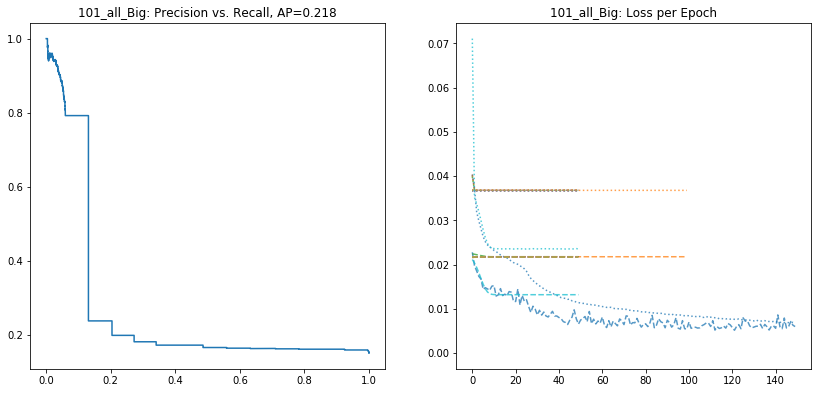

In [122]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,14))

filepaths={'101':'/home/hugh/processed_dv_101/','201':'/home/hugh/processed_dv_201/'}

augment={'all':'all','noise':'noise','xshift':'xshift','mirror':'mirror'}

#for batch in batch_sizes:
#    for lr in lrs:            
nkfolds=5
fpath='101'
### divide train and validation sets
kf = KFold(n_splits=nkfolds, shuffle=True)
files_all = np.sort(glob.glob(path.join(filepaths[fpath],'all','*info.npy')))
'''
#kepler_train_data = KeplerDataLoader(filepath=path.join(filepaths[fpath],'train'))
#kepler_val_data = KeplerDataLoader(filepath=path.join(filepaths[fpath],'val'))
'''

mod='Big'
aug='all'
### loop over folds
kcount = 0
precision_all, recall_all, ap_all = [], [], []
for train_index, val_index in kf.split(files_all):
    savename='exonet_CV'+str(kcount)+'_'+fpath+'_'+aug+'2_'+mod+'_centroids'
    if savename not in outputvals_cent.keys():
        model=ExtranetModel_101_cent().cuda()
        model=model.apply(weights_init)
        lr = 0.4e-5
        
        if kcount==0:
            #Loading the pre-training (eg random) state_dict
            init_statedict=model.state_dict().copy()
        else:
            #Loading the state_dict from pre-training.
            model.load_state_dict(init_statedict)

        optimizer=None
        optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=lr*0.025)
        criterion=None
        criterion = nn.BCELoss()
        batch_size = 32
        n_epochs = 50

        ### grab training and validation data
        files_train, files_val = files_all[train_index], files_all[val_index]
        kepler_val_data = KeplerDataLoaderCrossVal_cent(infofiles=files_val)
        kepler_train_data = KeplerDataLoaderCrossVal_cent(infofiles=files_train)

        #Loading balancer:
        fname=path.join(foldname,savename+'_BBS.pickle')
        if path.exists(fname):
            print("balancer exists")
            kepler_batch_sampler = pickle.load(open(fname,'rb'))
        else:
            kepler_batch_sampler = BalancedBatchSampler(batch_size, kepler_train_data, 2) #batch_size, dataset, n_classes
            pickle.dump(kepler_batch_sampler, open(fname,'wb'))

        kepler_data_loader = DataLoader(kepler_train_data, batch_sampler = kepler_batch_sampler, num_workers=4)
        kepler_val_loader = DataLoader(kepler_val_data, batch_size=batch_size, shuffle=False, num_workers=4)

        ### train model
        print("training "+savename)
        loss_train_epoch, loss_val_epoch, acc_val_epoch, ap_val_epoch, pred_val_final, gt_val_final  = train_model_cent(n_epochs, kepler_data_loader, kepler_val_loader, model, criterion, optimizer,augment=augment[aug])
        print("saving "+savename)
        torch.save(model.state_dict(),path.join(foldname,savename+'.pth'))

        outputvals_cent[savename]={'k':kcount,'fpath':fpath,'aug':aug,'mod':mod,'unqid':fpath+'_'+aug+'_'+mod,'pred_val_final':pred_val_final, 'gt_val_final':gt_val_final}
        for potkey in ['loss_train_epoch','loss_val_epoch','acc_val_epoch','ap_val_epoch']:
            exec('outputvals_cent[\''+savename+'\'][\''+potkey+'\']='+potkey)

    else:
        print("dictionary of trained values already exists")
        #outputvals_cent[savename]={'k':outputvals_cent[savename]['k'],'fpath':outputvals_cent[savename]['fpath'],
        #                            'aug':outputvals_cent[savename]['aug'],'mod':outputvals_cent[savename]['mod'],
        #                            'unqid':outputvals_cent[savename]['unqid'],'pred_val_final':outputvals_cent[savename]['pred_val_final'],
        #                            'gt_val_final':outputvals_cent[savename]['gt_val_final']}
        #for potkey in ['loss_train_epoch','loss_val_epoch','acc_val_epoch','ap_val_epoch']:
        #    exec('outputvals_cent[\''+savename+'\'][\''+potkey+'\']=outputvals_cent[\''+savename+'\'][\''+potkey+'\']')

        '''
        loss_train_epoch=outputvals_cent[savename]['loss_train_epoch']
        loss_val_epoch=outputvals_cent[savename]['loss_val_epoch']
        acc_val_epoch=outputvals_cent[savename]['acc_val_epoch']
        pred_val_final= outputvals_cent[savename]['pred_val_final']
        gt_val_final= outputvals_cent[savename]['gt_val_final']
        #tn, fp, fn, tp= outputvals_cent[savename]['matrix_0.5']
        #average_precision= outputvals_cent[savename]['average_precision_pl']

        #epoch_val_recall_pl,epoch_val_recall_ebs,epoch_val_recall_unk = recall_val
        #epoch_val_acc,epoch_val_acc_pl,epoch_val_acc_ebs,epoch_val_acc_unk = acc_val
        outputvals_cent[savename]={'loss_train_epoch':loss_train_epoch, 'loss_val_epoch':loss_val_epoch,
                  'acc_val_epoch':acc_val_epoch,'ap_val_epoch':ap_val_epoch,
                  'pred_val_final':pred_val_final, 'gt_val_final':gt_val_final,
                  'k':kcount,'fpath':fpath,'aug':aug,'mod':mod,'unqid':fpath+'_'+aug+'_'+mod}
        '''
    kcount+=1
    pickle.dump(outputvals_cent,open(path.join(foldname,savedicname+'.pickle'),'wb'))

print('#Assembling Cross-Val results after '+str(kcount)+' CVs')
dickeys=[key for key in outputvals_cent if (outputvals_cent[key]['unqid']==fpath+'_'+aug+'_'+mod)*~np.isnan(outputvals_cent[key]['k'])]
loss_train_epoch=[];loss_val_epoch=[];gt_val_final=[];pred_val_final=[]
ap_val_epoch=[];acc_val_epoch=[]
for key in dickeys:
    gt_val_final.append(outputvals_cent[key]['gt_val_final'])
    pred_val_final.append(outputvals_cent[key]['pred_val_final'])
    loss_train_epoch.append(outputvals_cent[key]['loss_train_epoch'])
    loss_val_epoch.append(outputvals_cent[key]['loss_val_epoch'])
    ap_val_epoch.append(outputvals_cent[key]['ap_val_epoch'])
    acc_val_epoch.append(outputvals_cent[key]['acc_val_epoch'])
gt_val_final=np.hstack(gt_val_final)
pred_val_final=np.hstack(pred_val_final)
loss_train_epoch=[np.hstack(l) for l in loss_train_epoch]
loss_val_epoch=[np.hstack(l) for l in loss_val_epoch]
ap_val_epoch=[np.hstack(l) for l in ap_val_epoch]
acc_val_epoch=[np.hstack(l) for l in acc_val_epoch]
### transform from loss per sample to loss per batch (multiple by batch size to compare to Chris')
#loss_train_batch = [x.item()* batch_size for x in loss_train_epoch]
#loss_val_batch = [x.item()* batch_size for x in loss_val_epoch]

### calculate average precision + precision-recall curves
P, R, _ = precision_recall_curve(gt_val_final, pred_val_final)
AP = average_precision_score(gt_val_final, pred_val_final, average=None)
print("average precision = {0:0.4f}".format(AP))

### convert prediction to bytes based on threshold
thresh = [0.9, 0.7, 0.5]
prec_thresh, recall_thresh = np.zeros(len(thresh)), np.zeros(len(thresh))
for n, nval in enumerate(thresh):
    pred_byte = np.zeros(len(pred_val_final))
    for i, val in enumerate(pred_val_final):
        if val > nval:
            pred_byte[i] = 1.0
        else:
            pred_byte[i] = 0.0
    prec_thresh[n] = precision_score(gt_val_final, pred_byte)
    recall_thresh[n] = recall_score(gt_val_final, pred_byte)
    print(savename,": thresh = {0:0.2f}, precision = {1:0.2f}, recall = {2:0.2f}".format(thresh[n], prec_thresh[n], recall_thresh[n]))
    tn, fp, fn, tp = confusion_matrix(gt_val_final, pred_byte).ravel()
    print(savename,":    TN = {0:0}, FP = {1:0}, FN = {2:0}, TP = {3:0}".format(tn, fp, fn, tp))
for key in dickeys:
    outputvals_cent[savename].update({'CV_P':P,'CV_R':R,'CV_AP':AP,'CV_matrix_0.5':[tn, fp, fn, tp]})

outputvals_cent['exonet_CVall_'+fpath+'_'+aug+'_'+mod]={'loss_train_epoch':loss_train_epoch, 'loss_val_epoch':loss_val_epoch,
                              'acc_val_epoch':acc_val_epoch,'ap_val_epoch':ap_val_epoch,
                              'pred_val_final':pred_val_final, 'gt_val_final':gt_val_final,
                              'k':np.nan,'fpath':fpath,'aug':aug,'mod':mod,'unqid':fpath+'_'+aug+'_'+mod,
                              'P':P,'R':R,'AP':AP,'matrix_0.5':[tn, fp, fn, tp]}

plt.clf()
plt.subplot(2,2,1)
### plot values
plt.step(R, P)
plt.title(fpath+'_'+aug+'_'+mod+': Precision vs. Recall, AP={0:0.3f}'.format(AP))

plt.subplot(2,2,2)
plt.title(fpath+'_'+aug+'_'+mod+': Loss per Epoch')
#plt.plot(np.arange(len(loss_train_batch)), loss_train_batch,color=sns.color_palette()[0])
#plt.plot(np.arange(len(loss_val_batch)), loss_val_batch,color=sns.color_palette()[1])
for n,key in enumerate(dickeys):
    plt.plot(np.array(outputvals_cent[key]['loss_train_epoch']),':',alpha=0.75,color=sns.color_palette()[n])
    plt.plot(np.array(outputvals_cent[key]['loss_val_epoch']),'--',alpha=0.75,color=sns.color_palette()[n])
    plt.plot([0.0,0.0],[0.0,0.0],'-',alpha=0.75,label="k="+str(outputvals_cent[key]['k']))
plt.plot([0.0,0.0],[0.0,0.0],'--',label='validation')
plt.plot([0.0,0.0],[0.0,0.0],':',label='training')
plt.legend(loc=2)

plt.subplot(2,2,3)
plt.title(fpath+'_'+aug+'_'+mod+': Average Precision per Epoch')
#plt.plot(np.arange(len(ap_val_epoch)), ap_val_epoch)
for key in dickeys:
    plt.plot(outputvals_cent[key]['ap_val_epoch'],'-',alpha=0.75)
    plt.plot([0.0,0.0],[0.0,0.0],'-',alpha=0.75,label="k="+str(outputvals_cent[key]['k']))
plt.legend(loc=4)

plt.subplot(2,2,4)
plt.title(fpath+'_'+aug+'_'+mod+': Accuracy per Epoch')
#plt.plot(np.arange(len(acc_val_epoch)), acc_val_epoch)
for key in dickeys:
    plt.plot(outputvals_cent[key]['acc_val_epoch'],':',alpha=0.75)
    plt.plot([0.0,0.0],[0.0,0.0],'-',alpha=0.75,label="k="+str(outputvals_cent[key]['k']))
plt.legend(loc=4)

plt.savefig(path.join(foldname,'exonet_CVall_'+fpath+'_'+aug+'_'+mod+".png"))
pickle.dump(outputvals_cent,open(path.join(foldname,savedicname+'.pickle'),'wb'))

With LR = 1e-5

LOSS: train  =   [0.02709127]  ,   val  =   0.014523319548119095  ,   acc  =   0.8532870638133796

LOSS: train  =   [0.0227688]  ,   val  =   0.013065480073568838  ,   acc  =   0.8532870638133796

... Acc gets stuck :/

With LR = 0.5e-5:

LOSS: train  =   [0.03308793]  ,   val  =   0.01901011984541808  ,   acc  =   0.8424908424908425

LOSS: train  =   [0.02296007]  ,   val  =   0.013639740937473641  ,   acc  =   0.8424908424908425

LOSS: train  =   [0.0230208]  ,   val  =   0.01363973652486836  ,   acc  =   0.8424908424908425

... Acc gets stuck :/

With LR = 0.2e-5:

LOSS: train  =   [0.0351423]  ,   val  =   0.020615969868048277  ,   acc  =   0.8538654328128013

LOSS: train  =   [0.02721931]  ,   val  =   0.015485367518480697  ,   acc  =   0.8538654328128013

LOSS: train  =   [0.02333767]  ,   val  =   0.013090011217195633  ,   acc  =   0.8538654328128013

... Acc gets stuck :/

REMOVED NAN/ZEROS FROM CENTROID STD - REDO CENTROID PROCESSING!

With LR = 0.5e-5:

LOSS: train  =   [0.03727083]  ,   val  =   0.021485666422478972  ,   acc  =   0.8488529014844804

LOSS: train  =   [0.02348866]  ,   val  =   0.013325201607816868  ,   acc  =   0.8488529014844804

CONSTANTLY STUCK

Ok, trying with centroids as sepearte layer (and with parameter reset and bias reset to zero)

In [99]:
model=ExtranetModel_101_cent().cuda()

In [100]:
model.state_dict()

OrderedDict([('fc_global.0.weight',
              tensor([[[ 0.1012, -0.1619,  0.3686, -0.1567,  0.2587]],
              
                      [[ 0.3961, -0.1553, -0.0419,  0.4275,  0.3696]],
              
                      [[ 0.3448,  0.2764,  0.3840,  0.4334,  0.2068]],
              
                      [[-0.1962,  0.3689,  0.1665, -0.0816, -0.1924]],
              
                      [[-0.3459,  0.1251, -0.1040,  0.3395, -0.3818]],
              
                      [[-0.3002, -0.4339, -0.0003, -0.4121,  0.1499]],
              
                      [[ 0.0687,  0.3025,  0.3894, -0.2284, -0.2569]],
              
                      [[-0.0896,  0.0574, -0.3589, -0.3632, -0.2667]],
              
                      [[-0.1507, -0.0200,  0.1980, -0.2160,  0.2357]],
              
                      [[-0.3168,  0.1713, -0.0664,  0.1121,  0.2851]],
              
                      [[-0.3029,  0.0234,  0.1531, -0.2024, -0.0706]],
              
                  

OrderedDict([('fc_global.0.weight',
              tensor([[[ 0.2448,  0.0602, -0.0118,  0.2417, -0.1691]],
              
                      [[-0.0071, -0.0817, -0.2364, -0.1718, -0.2627]],
              
                      [[-0.1579, -0.2384,  0.1108,  0.0435, -0.2597]],
              
                      [[ 0.0535,  0.1065,  0.0533,  0.2609, -0.2373]],
              
                      [[-0.0868, -0.2028,  0.1422, -0.0817,  0.0970]],
              
                      [[-0.0048,  0.0712,  0.0546,  0.1678,  0.1545]],
              
                      [[ 0.1922, -0.0577, -0.2565, -0.1893,  0.1228]],
              
                      [[ 0.0821,  0.1605, -0.0669,  0.1355, -0.2390]],
              
                      [[ 0.0829,  0.1810, -0.2465, -0.1306,  0.1469]],
              
                      [[-0.0402, -0.1287,  0.1146, -0.0897,  0.2022]],
              
                      [[-0.2242, -0.2585,  0.2228, -0.2027,  0.0526]],
              
                  

In [191]:
outputvals_cent[savename]={'k':kcount,'fpath':fpath,'aug':aug,'mod':mod,'unqid':fpath+'_'+aug+'_'+mod,'pred_val_final':pred_val_final, 'gt_val_final':gt_val_final}
for potkey in ['loss_train_epoch','loss_val_epoch','acc_val_epoch','ap_val_epoch']:
    exec('outputvals_cent[\''+savename+'\'][\''+potkey+'\']='+potkey)
pickle.dump(outputvals_cent,open(path.join(foldname,savedicname+'_cent.pickle'),'wb'))

In [128]:
type(x[2])

torch.Tensor

In [70]:
[key for key in outputvals_contd]

['exonet_CV0_101_all_XS',
 'exonet_CV1_101_all_XS',
 'exonet_CV2_101_all_XS',
 'exonet_CV3_101_all_XS',
 'exonet_CV4_101_all_XS',
 'exonet_CVall_101_all_XS',
 'exonet_CV0_101_noise_XS',
 'exonet_CV1_101_noise_XS',
 'exonet_CV2_101_noise_XS',
 'exonet_CV3_101_noise_XS',
 'exonet_CV4_101_noise_XS',
 'exonet_CVall_101_noise_XS',
 'exonet_CV0_101_xshift_XS',
 'exonet_CV1_101_xshift_XS',
 'exonet_CV2_101_xshift_XS',
 'exonet_CV3_101_xshift_XS',
 'exonet_CV4_101_xshift_XS',
 'exonet_CVall_101_xshift_XS',
 'exonet_CV0_101_mirror_XS',
 'exonet_CV1_101_mirror_XS',
 'exonet_CV2_101_mirror_XS',
 'exonet_CV3_101_mirror_XS',
 'exonet_CV4_101_mirror_XS',
 'exonet_CVall_101_mirror_XS',
 'exonet_CV0_101_all_Big',
 'exonet_CV1_101_all_Big',
 'exonet_CV2_101_all_Big',
 'exonet_CV3_101_all_Big',
 'exonet_CV4_101_all_Big',
 'exonet_CVall_101_all_Big',
 'exonet_CV0_101_noise_Big',
 'exonet_CV1_101_noise_Big',
 'exonet_CV2_101_noise_Big',
 'exonet_CV3_101_noise_Big',
 'exonet_CV4_101_noise_Big',
 'exonet_CV

In [65]:
for key in outputvals_contd:
    print(outputvals_contd[key].keys())
    print(outputvals_contd[key]['unqid'])

dict_keys(['k', 'loss_train_epoch', 'loss_val_epoch', 'acc_val_epoch', 'ap_val_epoch'])


KeyError: 'unqid'

In [38]:
type(loss_train_epoch)#, loss_val_epoch, acc_val_epoch, ap_val_epoch)

list

In [45]:
len(outputvals['exonet_CV0_101_all_XS']['loss_train_epoch'])

300

In [46]:
len(outputvals['exonet_CV0_101_all_XS']['loss_train_epoch']+outputvals['exonet_CV0_101_all_XS']['loss_train_epoch'])

600

In [47]:
savename

'exonet_CV4_201_mirror_Big'

In [51]:
loss_train_epoch=outputvals[savename]['loss_train_epoch']

In [59]:
outputvals_contd={}
outputvals_contd[savename]={'k':5}
for potkey in ['loss_train_epoch','loss_val_epoch','acc_val_epoch','ap_val_epoch']:
    print('outputvals_contd[\''+savename+'\'][\''+potkey+'\']=outputvals[\''+savename+'\'][\''+potkey+'\']+'+potkey)
    exec('outputvals_contd[\''+savename+'\'][\''+potkey+'\']=outputvals[\''+savename+'\'][\''+potkey+'\']+'+potkey)

outputvals_contd['exonet_CV4_201_mirror_Big']['loss_train_epoch']=outputvals['exonet_CV4_201_mirror_Big']['loss_train_epoch']+loss_train_epoch
outputvals_contd['exonet_CV4_201_mirror_Big']['loss_val_epoch']=outputvals['exonet_CV4_201_mirror_Big']['loss_val_epoch']+loss_val_epoch
outputvals_contd['exonet_CV4_201_mirror_Big']['acc_val_epoch']=outputvals['exonet_CV4_201_mirror_Big']['acc_val_epoch']+acc_val_epoch
outputvals_contd['exonet_CV4_201_mirror_Big']['ap_val_epoch']=outputvals['exonet_CV4_201_mirror_Big']['ap_val_epoch']+ap_val_epoch


In [60]:
outputvals_contd

{'exonet_CV4_201_mirror_Big': {'k': 5,
  'loss_train_epoch': [array([0.0095215], dtype=float32),
   array([0.00503225], dtype=float32),
   array([0.00431049], dtype=float32),
   array([0.00384206], dtype=float32),
   array([0.00327061], dtype=float32),
   array([0.00284683], dtype=float32),
   array([0.00240302], dtype=float32),
   array([0.00213781], dtype=float32),
   array([0.00199263], dtype=float32),
   array([0.00175735], dtype=float32),
   array([0.00147505], dtype=float32),
   array([0.00134845], dtype=float32),
   array([0.00122727], dtype=float32),
   array([0.00112665], dtype=float32),
   array([0.00115904], dtype=float32),
   array([0.00138941], dtype=float32),
   array([0.00120968], dtype=float32),
   array([0.00105451], dtype=float32),
   array([0.00106463], dtype=float32),
   array([0.000921], dtype=float32),
   array([0.00098539], dtype=float32),
   array([0.00100998], dtype=float32),
   array([0.00056352], dtype=float32),
   array([0.00085802], dtype=float32),
   array

In [58]:
outputvals['exonet_CV4_201_mirror_Big']['loss_train_epoch']

[array([0.0095215], dtype=float32),
 array([0.00503225], dtype=float32),
 array([0.00431049], dtype=float32),
 array([0.00384206], dtype=float32),
 array([0.00327061], dtype=float32),
 array([0.00284683], dtype=float32),
 array([0.00240302], dtype=float32),
 array([0.00213781], dtype=float32),
 array([0.00199263], dtype=float32),
 array([0.00175735], dtype=float32),
 array([0.00147505], dtype=float32),
 array([0.00134845], dtype=float32),
 array([0.00122727], dtype=float32),
 array([0.00112665], dtype=float32),
 array([0.00115904], dtype=float32),
 array([0.00138941], dtype=float32),
 array([0.00120968], dtype=float32),
 array([0.00105451], dtype=float32),
 array([0.00106463], dtype=float32),
 array([0.000921], dtype=float32),
 array([0.00098539], dtype=float32),
 array([0.00100998], dtype=float32),
 array([0.00056352], dtype=float32),
 array([0.00085802], dtype=float32),
 array([0.0003999], dtype=float32),
 array([0.00045191], dtype=float32),
 array([0.00048713], dtype=float32),
 arra

In [53]:
outputvals['exonet_CV4_201_mirror_Big']['loss_train_epoch']+loss_train_epoch

[array([0.0095215], dtype=float32),
 array([0.00503225], dtype=float32),
 array([0.00431049], dtype=float32),
 array([0.00384206], dtype=float32),
 array([0.00327061], dtype=float32),
 array([0.00284683], dtype=float32),
 array([0.00240302], dtype=float32),
 array([0.00213781], dtype=float32),
 array([0.00199263], dtype=float32),
 array([0.00175735], dtype=float32),
 array([0.00147505], dtype=float32),
 array([0.00134845], dtype=float32),
 array([0.00122727], dtype=float32),
 array([0.00112665], dtype=float32),
 array([0.00115904], dtype=float32),
 array([0.00138941], dtype=float32),
 array([0.00120968], dtype=float32),
 array([0.00105451], dtype=float32),
 array([0.00106463], dtype=float32),
 array([0.000921], dtype=float32),
 array([0.00098539], dtype=float32),
 array([0.00100998], dtype=float32),
 array([0.00056352], dtype=float32),
 array([0.00085802], dtype=float32),
 array([0.0003999], dtype=float32),
 array([0.00045191], dtype=float32),
 array([0.00048713], dtype=float32),
 arra

In [39]:
key

'exonet_CV4_101_all_XS'

In [51]:
outputvals['exonet_CV4_101_all_XS']['loss_train_epoch']

[array([0.10421488], dtype=float32),
 array([0.10420503], dtype=float32),
 array([0.10462302], dtype=float32)]

In [ ]:
pickle.dump(outputvals,open(path.join(foldname,savedicname+'.pickle'),'wb'))

In [44]:
crit=nn.BCELoss()
crit(outputvals[key]['pred_val_final'],outputvals[key]['gt_val_final'])

TypeError: 'int' object is not callable

In [1]:
epoch_val_loss

NameError: name 'epoch_val_loss' is not defined

In [39]:
nn.BCELoss?

In [31]:
outputvals[key]['pred_val_final']

array([0.        , 0.        , 0.        , ..., 0.        , 0.12614669,
       0.11938311], dtype=float32)

In [32]:
outputvals[key]['gt_val_final']

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [71]:
np.shape(gt_val_final[0])

(5187,)

In [16]:
ls *.pickle

balanced_2class_nocents_101_dv_auxdata_tess_dataset.pickle
balanced_2class_nocents_101_dv_tess_dataset.pickle
balanced_2class_nocents_101_tess_dataset.pickle
balanced_2class_nocents_201_dv_tess_dataset.pickle
balanced_2class_nocents_tess_dataset.pickle
balanced_2class_tess_dataset.pickle
exonet_101_none_XS.pickle
exonet_101.pickle
exonet_201.pickle
exonet_3class_101.pickle
exonet_3class_201.pickle
output_dict_multi3_exonet.pickle


In [17]:
import pickle
outputvals=pickle.load(open('output_dict_binary_e','rb'))
from IPython.display import Image
import IPython.display as dp

images = []
for runname in outputvals:
    images.append(dp.Image(filename=runname+".png", format='png'))

# display all images
for n in range(len(images)):
    ea=images[n]
    dp.display_png(ea)
    print(list(outputvals.keys())[n])

FileNotFoundError: [Errno 2] No such file or directory: 'output_dict_binary_e'

In [28]:
### initialize model; cuda puts it on GPU
model = ExtranetModel_101().cuda()

### optimizer for learning
lr = 1.5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### loss function
criterion = nn.BCELoss()

### batch size
batch_size = 64

### number of epochs
n_epochs = 400

In [29]:
### grab data
kepler_train_data = KeplerDataLoader(filepath='/home/hugh/processed_dv_101/train')
kepler_val_data = KeplerDataLoader(filepath='/home/hugh/processed_dv_101/val')

In [30]:
from os import path
import pickle
fname='balanced_2class_nocents_101_dv_tess_dataset.pickle'
if path.exists(fname):
    kepler_batch_sampler = pickle.load(open(fname,'rb'))
else:
    kepler_batch_sampler = BalancedBatchSampler(batch_size, kepler_train_data, 2) #batch_size, dataset, n_classes
    pickle.dump(kepler_batch_sampler, open(fname,'wb'))

In [31]:
### load data
kepler_data_loader = DataLoader(kepler_train_data, batch_sampler = kepler_batch_sampler, num_workers=4)
kepler_val_loader = DataLoader(kepler_val_data, batch_size=batch_size, shuffle=False, num_workers=4)

In [32]:
for x_train_data, y_train in kepler_data_loader:

    ### get local view, global view, and label for training
    x_train_local, x_train_global, x_train_star = x_train_data

    x_train_local = Variable(x_train_local).type(torch.FloatTensor).cuda()
    break

In [45]:
np.shape(local_stds[:roundn])

(35, 101)

In [48]:
local_stds

array([0.3104949 , 0.19332148, 0.16571361, 0.30263424, 0.2568697 ,
       0.23017159, 0.22420129, 0.28905296, 0.18179056, 0.19634628,
       0.21672797, 0.21053435, 0.253703  , 0.24512766, 0.18526301,
       0.19354528, 0.20515218, 0.21828526, 0.25526178, 0.2778623 ,
       0.22231571, 0.23471211, 0.24181873, 0.17698386, 0.2223023 ,
       0.21134433, 0.22418943, 0.20619434, 0.23044309, 0.2860098 ,
       0.24011365, 0.23271301, 0.23681004, 0.21058494, 0.27523062,
       0.29131085, 0.2735954 , 0.32620978, 0.2716096 , 0.31779388,
       0.22407229, 0.29636604, 0.2558426 , 0.32408857, 0.25012487,
       0.24762379, 0.27158225, 0.24765004, 0.26510918, 0.301274  ,
       0.3238664 , 0.23465028, 0.24234408, 0.33868286, 0.21578245,
       0.17494325, 0.1778552 , 0.20382433, 0.30648482, 0.26350126,
       0.2828583 , 0.2029524 , 0.2636463 , 0.20098051, 0.23086424,
       0.23520589, 0.2701445 , 0.30773053, 0.27167425, 0.24339308],
      dtype=float32)

In [41]:
roundn

101.0

In [40]:
np.shape(local_stds[:roundn,:])

TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
### train model
loss_train_epoch, loss_val_epoch, acc_val_epoch, ap_val_epoch, pred_val_final, gt_val_final  = train_model(n_epochs, kepler_data_loader, kepler_val_loader, model, criterion, optimizer)

### transform from loss per sample to loss per batch (multiple by batch size to compare to Chris')
loss_train_batch = [x.item()* batch_size for x in loss_train_epoch]
loss_val_batch = [x.item()* batch_size for x in loss_val_epoch]

In [ ]:
for data in kepler_data_loader:
    break

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(14,14))
for n in range(64):
    print(np.sum(np.isnan(data[0][0][n].cpu().numpy())),np.sum(np.isnan(data[0][1][n].cpu().numpy())),np.sum(np.isnan(data[0][2][n].cpu().numpy())))
    plt.subplot(121)
    plt.plot(n+data[0][0][n].cpu().numpy(),'.',color='C'+str(int(data[1][n])),alpha=0.66)
    plt.subplot(122)
    plt.plot(n+data[0][1][n].cpu().numpy(),'.',color='C'+str(int(data[1][n])),alpha=0.66)
for n in range(1,3):
    plt.subplot(1,2,n)
    plt.ylim(-2,65)
plt.tight_layout()
plt.savefig('InputExamples.png')

In [ ]:
n_epochs = 100

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(211)
plt.plot(loss_val_batch[1:])
plt.subplot(212)
plt.plot(loss_train_batch[1:])
plt.xlim(0,200)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(211)
plt.plot(loss_val_batch)
#plt.ylim(0.7,0.703)
plt.subplot(212)
plt.plot(loss_train_batch)


In [ ]:
### setup output of run for ensembling
run = 0
path = '/data_sata1/ensembling/extranet_xs_ensembling'

### output predictions & ground truth
pt_fname = os.path.join(path, 'r' + str(run).zfill(2) + '-i' + str(n_epochs) + '-lr' + str(lr) + '-pt.csv')
while os.path.isfile(pt_fname):
    run +=1
    pt_fname = os.path.join(path, 'r' + str(run).zfill(2) + '-i' + str(n_epochs) + '-lr' + str(lr) + '-pt.csv')
df = pd.DataFrame({"gt" : gt_val_final, "pred" : pred_val_final})
df.to_csv(pt_fname, index=False)

### output per-iteration values
epochs_fname = os.path.join(path, 'r' + str(run).zfill(2) + '-i' + str(n_epochs) + '-lr' + str(lr) + '-epoch.csv')
df = pd.DataFrame({"loss_train":loss_train_batch, "loss_val":loss_val_batch, "acc_val":acc_val_epoch, "ap_val":ap_val_epoch})
df.to_csv(epochs_fname, index=False)

### save model
model_fname = os.path.join(path, 'r' + str(run).zfill(2) + '-i' + str(n_epochs) + '-lr' + str(lr) + '-model.pth')
torch.save(model.state_dict(), model_fname)

In [ ]:
### calculate average precision + precision-recall curves
P, R, _ = precision_recall_curve(gt_val_final, pred_val_final)
AP = average_precision_score(gt_val_final, pred_val_final, average=None)
print("average precision = {0:0.4f}".format(AP))
  
### convert prediction to bytes based on threshold
thresh = [0.5, 0.6, 0.7, 0.8, 0.9]
prec_thresh, recall_thresh = np.zeros(len(thresh)), np.zeros(len(thresh))
for n, nval in enumerate(thresh):
    pred_byte = np.zeros(len(pred_val_final))
    for i, val in enumerate(pred_val_final):
        if val > nval:
            pred_byte[i] = 1.0
        else:
            pred_byte[i] = 0.0
    prec_thresh[n] = precision_score(gt_val_final, pred_byte)
    recall_thresh[n] = recall_score(gt_val_final, pred_byte)
    print("thresh = {0:0.2f}, precision = {1:0.2f}, recall = {2:0.2f}".format(thresh[n], prec_thresh[n], recall_thresh[n]))
    tn, fp, fn, tp = confusion_matrix(gt_val_final, pred_byte).ravel()
    print("   TN = {0:0}, FP = {1:0}, FN = {2:0}, TP = {3:0}".format(tn, fp, fn, tp))

In [ ]:
### plot values
p1 = figure(plot_width=400, plot_height=300, title='Precision vs. Recall, AP={0:0.3f}'.format(AP))
p1.step(R, P, color="blue", line_width=2, mode="after")

p2 = figure(plot_width=400, plot_height=300, title='Loss per Epoch')
p2.line(np.arange(len(loss_train_batch)), loss_train_batch, color="blue", line_width=2)
p2.line(np.arange(len(loss_val_batch)), loss_val_batch, color="orange", line_width=1)
show(row(p1, p2))

p3 = figure(plot_width=400, plot_height=300, title='Average Precision per Epoch')
p3.line(np.arange(len(ap_val_epoch)), ap_val_epoch, color="orange", line_width=2)
p3.scatter(np.arange(len(ap_val_epoch)), ap_val_epoch, color="orange", alpha=0.5)

p4 = figure(plot_width=400, plot_height=300, title='Accuracy per Epoch')
p4.line(np.arange(len(acc_val_epoch)), acc_val_epoch, color="orange", line_width=2)
p4.scatter(np.arange(len(acc_val_epoch)), acc_val_epoch, color="orange", alpha=0.5)
show(row(p3, p4))


In [126]:
ls /home/hugh/processed_dv_101/

all/  test/  train/  val/


In [123]:
os.mkdir('processed_101bins_noUNK/')
os.mkdir('processed_101bins_noUNK/all')

In [138]:
for file in glob.glob('/home/hugh/processed_dv_101/all/*info.npy'):
    info=np.load(file,encoding='latin1')
    if info[6]!='UNK':
        os.system('cp --preserve=links '+file+' processed_101bins_noUNK/all')
        os.system('cp --preserve=links '+file.replace('_info','_loc')+' processed_101bins_noUNK/all')
        os.system('cp --preserve=links '+file.replace('_info','_glob')+' processed_101bins_noUNK/all')
        os.system('cp --preserve=links '+file.replace('_info','_sec')+' processed_101bins_noUNK/all')
        os.system('cp --preserve=links '+file.replace('_info','_odd_even')+' processed_101bins_noUNK/all')